In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [3]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [4]:
df = df.entry.apply(parse_log_entry)

In [ ]:
df.head()

In [5]:
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [6]:
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

In [7]:
# ip count in df
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'count'})
ip_df.head()

,ip,count
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,24.26.242.9,21


In [8]:
# proba for each ip in df
ip_df2 = pd.DataFrame((df.ip.value_counts(dropna=False))/df.ip.count()).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'proba'})
ip_df2.head()

,ip,proba
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,24.26.242.9,0.001503


In [9]:
# merge df
ip_df = ip_df.merge(ip_df2, on='ip')
ip_df.head()

,ip,count,proba
0,97.105.19.58,11998,0.858595
1,173.173.113.51,1059,0.075784
2,72.181.113.170,613,0.043867
3,72.181.105.81,246,0.017604
4,24.26.242.9,21,0.001503


In [10]:
# see how many ip addresses there are 
ip_df.set_index('ip')['count'].sort_values()

ip
54.145.52.184         1
52.91.30.150          1
3.88.129.158          1
34.207.64.242         1
54.172.14.223         1
34.229.70.250         1
35.174.209.2          1
3.92.201.136          1
52.90.165.200         1
45.23.250.16          1
52.87.230.102         2
70.121.214.34         2
35.175.171.137        2
68.201.219.223       21
24.26.242.9          21
72.181.105.81       246
72.181.113.170      613
173.173.113.51     1059
97.105.19.58      11998
Name: count, dtype: int64

<AxesSubplot:ylabel='ip'>

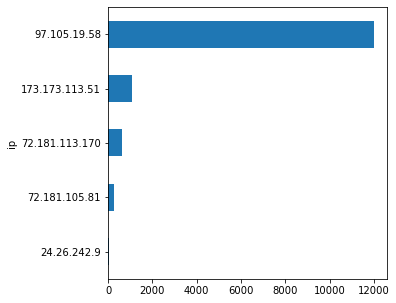

In [11]:
ip_df.set_index('ip')['count'].sort_values().tail().plot.barh(figsize=(5,5))

In [ ]:
df.head()

### Exploring request_path

In [12]:
df.request_path.value_counts()

/api/v1/sales?page=2                 709
/api/v1/items                        464
/api/v1/items?page=2                 291
/api/v1/items?page=3                 219
/api/v1/stores                       162
                                    ... 
/api/v1/items?page=0                   1
/api/v1/stores?page=999                1
/api/v1/stores?page=2                  1
/api/v1/stores?page=666                1
/api/v1/items/api/v1/items?page=3      1
Name: request_path, Length: 218, dtype: int64

In [13]:
# path count in df
path_df = pd.DataFrame(df.request_path.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'request_path', 'request_path': 'count'})
path_df.head()

,request_path,count
0,/api/v1/sales?page=2,709
1,/api/v1/items,464
2,/api/v1/items?page=2,291
3,/api/v1/items?page=3,219
4,/api/v1/stores,162


In [14]:
# proba for each path in df
path_df2 = pd.DataFrame((df.request_path.value_counts(dropna=False))/df.request_path.count()).reset_index().\
                rename(columns={'index': 'request_path', 'request_path': 'proba'})
path_df2.head()

,request_path,proba
0,/api/v1/sales?page=2,0.050737
1,/api/v1/items,0.033205
2,/api/v1/items?page=2,0.020824
3,/api/v1/items?page=3,0.015672
4,/api/v1/stores,0.011593


In [15]:
# merge df
path_df = path_df.merge(path_df2, on='request_path')
path_df.head()

,request_path,count,proba
0,/api/v1/sales?page=2,709,0.050737
1,/api/v1/items,464,0.033205
2,/api/v1/items?page=2,291,0.020824
3,/api/v1/items?page=3,219,0.015672
4,/api/v1/stores,162,0.011593


In [17]:
# see how many ip addresses there are 
path_df.set_index('request_path')['count'].sort_values()

request_path
/api/v1/items/api/v1/items?page=3            1
/api/v1/items?page=4                         1
/api/v1/items&page=0                         1
/api/v1/items?page=99999999999999999998      1
/api/V1/HiZach!                              1
                                          ... 
/api/v1/stores                             162
/api/v1/items?page=3                       219
/api/v1/items?page=2                       291
/api/v1/items                              464
/api/v1/sales?page=2                       709
Name: count, Length: 218, dtype: int64

<AxesSubplot:ylabel='request_path'>

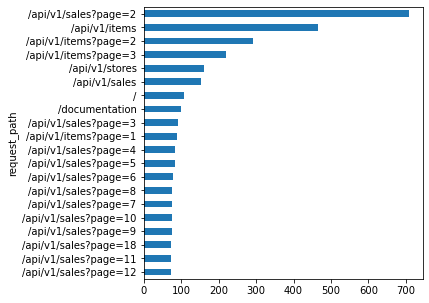

In [21]:
path_df.set_index('request_path')['count'].sort_values().tail(20).plot.barh(figsize=(5,5))

In [22]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Exploring user_agent

In [23]:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12001
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [24]:
# user agent count in df

user_df = pd.DataFrame(df.user_agent.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'user_agent', 'user_agent':'count'})
user_df.head()

,user_agent,count
0,python-requests/2.21.0,12001
1,python-requests/2.20.1,1911
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7


In [27]:
# proba for each user agent in df
user_df2 = pd.DataFrame((df.user_agent.value_counts(dropna=False))/df.user_agent.count()).reset_index().\
                rename(columns={'index': 'user_agent', 'user_agent': 'proba'})
user_df2.head()

,user_agent,proba
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501


In [28]:
# merge df
user_df = user_df.merge(user_df2, on='user_agent')
user_df.head()

,user_agent,count,proba
0,python-requests/2.21.0,12001,0.858809
1,python-requests/2.20.1,1911,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501


<AxesSubplot:ylabel='user_agent'>

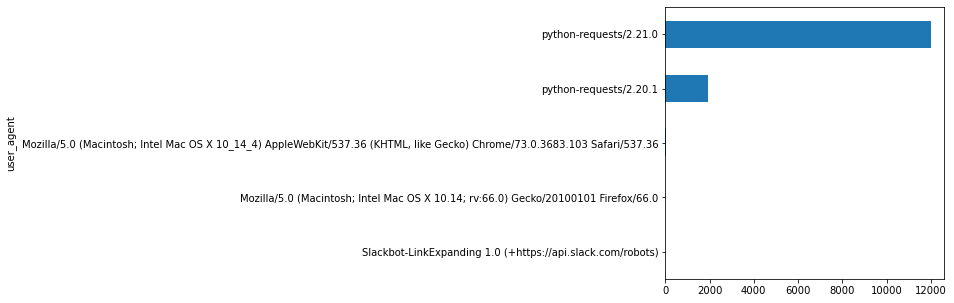

In [31]:
# see how many user agents there are 
user_df.set_index('user_agent')['count'].sort_values().tail().plot.barh(figsize=(5,5))

In [32]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Exploring status_code 

In [33]:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

In [34]:
# status code count in df

status_df = pd.DataFrame(df.status_code.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'status_code', 'status_code':'count'})
status_df.head()

,status_code,count
0,200,13958
1,499,16


In [35]:
# proba for each user agent in df
status_df2 = pd.DataFrame((df.status_code.value_counts(dropna=False))/df.status_code.count()).reset_index().\
                rename(columns={'index': 'status_code', 'status_code': 'proba'})
status_df2.head()

,status_code,proba
0,200,0.998855
1,499,0.001145


In [36]:
# merge df
status_df = status_df.merge(status_df2, on='status_code')
status_df.head()

,status_code,count,proba
0,200,13958,0.998855
1,499,16,0.001145


<AxesSubplot:ylabel='status_code'>

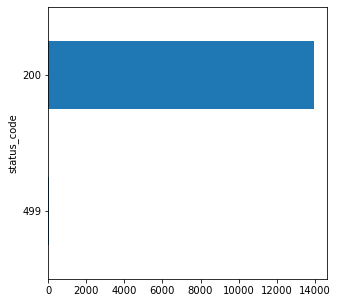

In [37]:
# see how many user agents there are 
status_df.set_index('status_code')['count'].sort_values().tail().plot.barh(figsize=(5,5))

Probability of a certain status code given user agent?

HTTP Status Codes

- 200: ok
- 3xx: redirects
- 4xx: client level errors -- the requester did something wrong
- 5xx: server level errors -- the server did something wrong

In [38]:
Pab = df.groupby(['user_agent', 'status_code']).size()/len(df)

In [39]:
Pab

user_agent                                                                                                                 status_code
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                         200            0.000572
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36  200            0.000143
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36  200            0.000286
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36  200            0.002433
Python-urllib/3.7                                                                                                          200            0.000072
Slackbot 1.0 (+https://api.slack.com/robots)                                                                               200    

In [40]:
Pb = df.groupby('user_agent').size()/len(df)
Pb

user_agent
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                           0.000572
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36    0.000143
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.000286
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36    0.002433
Python-urllib/3.7                                                                                                            0.000072
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                 0.000429
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                   0.000501
python-requests/2.20.1                             

In [41]:
Pab / Pb

user_agent                                                                                                                 status_code
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                         200            1.000000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.121 Safari/537.36  200            1.000000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36  200            1.000000
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36  200            1.000000
Python-urllib/3.7                                                                                                          200            1.000000
Slackbot 1.0 (+https://api.slack.com/robots)                                                                               200    

In [42]:
# Given a particular user agent, what is probability of a certain status code
status_given_agent = (
    df.groupby('user_agent')\
    .status_code.value_counts(normalize=True)\
    .rename('proba_status_given_agent')\
    .reset_index())
status_given_agent

,user_agent,status_code,proba_status_given_agent
0,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,200,1.000000
1,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.000000
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,200,1.000000
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,200,1.000000
4,Python-urllib/3.7,200,1.000000
5,Slackbot 1.0 (+https://api.slack.com/robots),200,1.000000
6,Slackbot-LinkExpanding 1.0 (+https://api.slack...,200,1.000000
7,python-requests/2.20.1,200,0.997907
8,python-requests/2.20.1,499,0.002093
9,python-requests/2.21.0,200,0.999000


In [43]:
status_given_agent[status_given_agent.proba_status_given_agent < 1]

,user_agent,status_code,proba_status_given_agent
7,python-requests/2.20.1,200,0.997907
8,python-requests/2.20.1,499,0.002093
9,python-requests/2.21.0,200,0.999000
10,python-requests/2.21.0,499,0.001000


In [50]:
df[(df.user_agent != 'python-requests/2.20.1') & (df.user_agent != 'python-requests/2.21.0')].sort_values(by='status_code', ascending=False)


,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:38:16,97.105.19.58,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
2019-04-16 23:44:34,72.181.105.81,GET,/,HTTP/1.1,200,42,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
2019-04-16 21:22:22,35.175.171.137,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
2019-04-16 21:22:22,54.145.52.184,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
2019-04-16 21:22:23,52.87.230.102,GET,/api/v1/sales,HTTP/1.1,200,493905,Slackbot-LinkExpanding 1.0 (+https://api.slack...
...,...,...,...,...,...,...,...
2019-04-16 19:49:58,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
2019-04-16 19:59:46,97.105.19.58,GET,/api/v1/helloclass!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
2019-04-16 19:59:47,97.105.19.58,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
